In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Part 1: Network Analysis

In [ ]:
G = nx.read_graphml("data/world_graph_attributes.graphml")

In [4]:
isolated_nodes = list(nx.isolates(G))
print("Isolated nodes:", isolated_nodes)

Isolated nodes: ['Saint_Vincent_and_the_Grenadines']


## 1. Qualitative Analysis

The **in-degree** of a node represents how many countries mention that particular country, showing which countries influence world history the most. These are the United States, United Kingdom and France.

The **out-degree** represents how many countries are part of the node's country history. It reveals countries which were influenced my many other countries. These are Iran, Russia and Argentina.

The **total degree** corresponds to the sum of in and out-degree and it should represent the balance betweene the influence of a country and how influenced by others it is. However, by the results shown above, the in-degree values are way higher than the out-degree ones, so the total distribution will most likely be dominated by the in-degree. Countries with top total degree are the United States, the United Kingdom and France, the same as for the in-degree, as predicted.

In [6]:
no_nodes = G.number_of_nodes()
no_edges=G.number_of_edges()
print("Number of nodes:", no_nodes)
print("Number of edges:", no_edges)

#Highest in
in_degrees = dict(G.in_degree())
sorted_nodes_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
highest_in=sorted_nodes_in[:3]
print("\nHighest in-degree nodes and their in-degree value:", highest_in)

#Highest out 
out_degrees = dict(G.out_degree())
sorted_nodes_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
highest_out=sorted_nodes_out[:10]
print(" \nHighest out-degree nodes and their out-degree value:", highest_out)

#Highest total
total_degrees = dict(G.degree())
sorted_nodes_total = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)
highest_total=sorted_nodes_total[:3]
print("\nHighest total-degree nodes and their total-degree value:", highest_total)

Number of nodes: 192
Number of edges: 1854

Highest in-degree nodes and their in-degree value: [('United_States', 107), ('France', 85), ('United_Kingdom', 81)]
 
Highest out-degree nodes and their out-degree value: [('Iran', 26), ('Russia', 24), ('Argentina', 22), ('Israel', 21), ('Sweden', 21), ('Cuba', 20), ('South_Africa', 20), ('Yemen', 20), ('Libya', 19), ('Equatorial_Guinea', 19)]

Highest total-degree nodes and their total-degree value: [('United_States', 124), ('United_Kingdom', 99), ('France', 93)]


From the scatter plot, we conclude that the range for the out-degree is way smaller than for the in-degree, as seen before. We can also see that while nodes are spread along for the out degree, for the in degree they tend to have values lower than 20. There seems to be some countries dominating the world ...

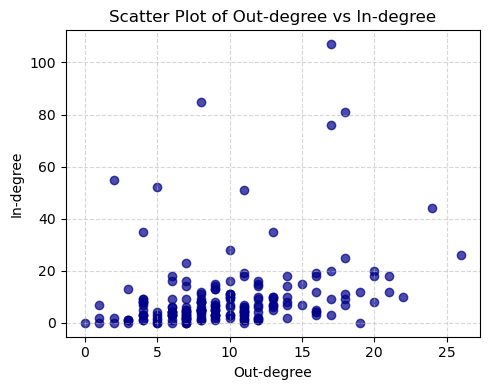

In [7]:
# in-degree and out-degree lists
in_d = [d for _, d in G.in_degree()]
out_d = [d for _, d in G.out_degree()]

plt.figure(figsize=(5, 4))
plt.scatter(out_d, in_d, marker='o', color='darkblue', alpha=0.7)
plt.title('Scatter Plot of Out-degree vs In-degree')
plt.xlabel('Out-degree')
plt.ylabel('In-degree')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 2. Degree distributions

### 2.1. In-degree and out-degree distributions

In [ ]:
in_d_sort = sorted(in_d)
out_d_sort = sorted(out_d)

# bins
max_deg = max(max(in_d_sort), max(out_d_sort))
min_deg = min(min(in_d_sort), min(out_d_sort))
v = np.arange(min_deg, max_deg + 2)  

# in counts
in_counts, in_bins = np.histogram(in_d_sort, bins=v)
# in probabilities
in_probs = in_counts / in_counts.sum()

# out counts
out_counts, out_bins = np.histogram(out_d_sort, bins=v)
# out probabilities
out_probs = out_counts / out_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(v[:-1]-0.2, in_probs, width=0.4, color='darkblue', label='In-degree', alpha=0.7)
axes[0].bar(v[:-1]+0.2, out_probs, width=0.4, color='darkorange', label='Out-degree', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('In- and Out-degree Probability Distribution')
axes[0].legend()

axes[1].scatter(v[:-1], in_probs, marker='o', color='darkblue', label='In-degree', alpha=0.7)
axes[1].scatter(v[:-1], out_probs, marker='x', color='darkorange', label='Out-degree', alpha=0.7)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log In- and Out-degree Probability Distribution')
axes[1].legend()

plt.show()

Check powerlaw

In [ ]:
fit_in = powerlaw.Fit(in_d,discrete=True,verbose=False)
alpha_in = fit_in.alpha
xmin_in=fit_in.xmin
print("In-degree exponent (alpha):", alpha_in)
print("xmin:", xmin_in)

fit_out = powerlaw.Fit(out_d,discrete=True,verbose=False)
alpha_out = fit_out.alpha
xmin_out=fit_out.xmin
print("Out-degree exponent (alpha):", alpha_out)
print("xmin:", xmin_out)

Compare distributions

In [ ]:
print("In-degree distribution model comparisons:")
R_ln_in, p_ln_in = fit_in.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_in, ", p =", p_ln_in)

R_exp_in, p_exp_in = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_in, ", p =", p_exp_in)

R_expln_in, p_expln_in = fit_in.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_in, ", p =", p_expln_in)

print("\nOut-degree distribution model comparisons:")
R_ln_out, p_ln_out = fit_out.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_out.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_out.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

### 2.2. Total-degree distribution

In [ ]:
total_d = [d for _, d in G.degree()]
total_d_sort = sorted(total_d)

max_total=max(total_d_sort)
min_total=min(total_d_sort)
v_total=np.arange(min_total, max_total+2)

# counts
total_counts, total_bins = np.histogram(total_d_sort, bins=v_total)
# probabilities
total_probs = total_counts / total_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(total_bins[:-1], total_counts, width=np.diff(total_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Total-Degree Probability Distribution')
    
axes[1].scatter(total_bins[:-1], total_counts, marker='o', color = 'darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log Total-Degree Probability Distribution')
plt.show()

Powerlaw and distributions

In [ ]:
fit_total = powerlaw.Fit(total_d,discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin
print("In-degree exponent (alpha):", alpha_total)
print("xmin:", xmin_total)

R_ln_out, p_ln_out = fit_total.distribution_compare('power_law', 'lognormal')
print("\nPower-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_total.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_total.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

## 3. Comparar GDP com Sentiment Score attribute

In [ ]:
from scipy.stats import pearsonr

length_of_content = np.array(list(nx.get_node_attributes(G, 'length_of_content').values()))
out_degree = np.array(list(dict(G.out_degree()).values()))
in_degree = np.array(list(dict(G.in_degree()).values()))

pearson_out = pearsonr(length_of_content, out_degree)
pearson_in = pearsonr(length_of_content, in_degree)
print("Pearson correlation (Out-Degree):", pearson_out[0])
print("Pearson correlation (In-Degree):", pearson_in[0])

## 4. Centrality